**IMPORTING ALL NEEDED LIBRARIES.**

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error as mae
import itertools
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
drive.mount('/content/gdrive')


Mounted at /content/gdrive


**IMPORTATING DATASET FROM DRIVE**

In [ ]:
Data= pd.read_excel(r'/content/gdrive/MyDrive/mydata.xlsx')
print(Data)

        sl no.     data
0   2010-01-01  216.687
1   2010-02-01  216.741
2   2010-03-01  217.631
3   2010-04-01  218.009
4   2010-05-01  218.178
..         ...      ...
143 2021-12-01  278.802
144 2022-01-01  281.148
145 2022-02-01  283.716
146 2022-03-01  287.504
147 2022-04-01  289.109

[148 rows x 2 columns]


**STORING THE DATA IN DATAFRAME.**

Text(0, 0.5, 'Data')

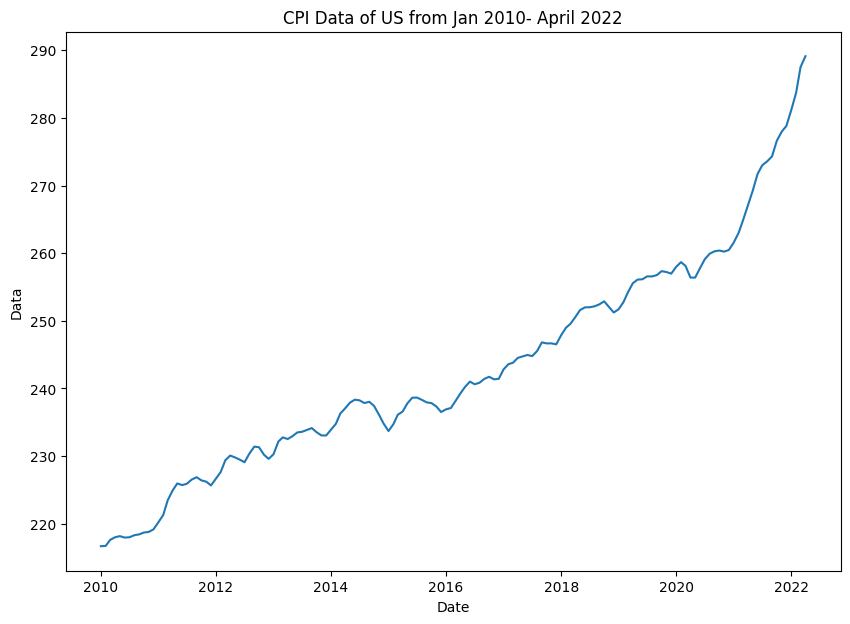

In [ ]:
df = pd.DataFrame(Data, columns = ['sl no.', 'data'])
df.index = df['sl no.']
del df['sl no.']
plt.figure(figsize=(10,7))
plt.plot(df)
plt.title("CPI Data of US from Jan 2010- April 2022")
plt.xlabel("Date")
plt.ylabel("Data")

**TESTING IF THE DATA IS STATIONARY OR NOT BY USING AD FULLER TEST.**

where,we test,

H0:the data is not stationary against H1:the data is stationary

If the value of the ADF Statistic is less than all the Critical values, then we reject the test.

In [ ]:
atest=adfuller(df['data'])
print("ADF statistic: ",atest[0])
print("P-value: ",atest[1])
for key, value in atest[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF statistic:  2.654840010451784
P-value:  0.9990832963294357
Critial Values:
   1%, -3.476273058920005
Critial Values:
   5%, -2.881687616548444
Critial Values:
   10%, -2.5775132580261593


Hence,we accept H0.

The data is not Staionary.

We further decompose the data to get an idea of all the components present in the Data.

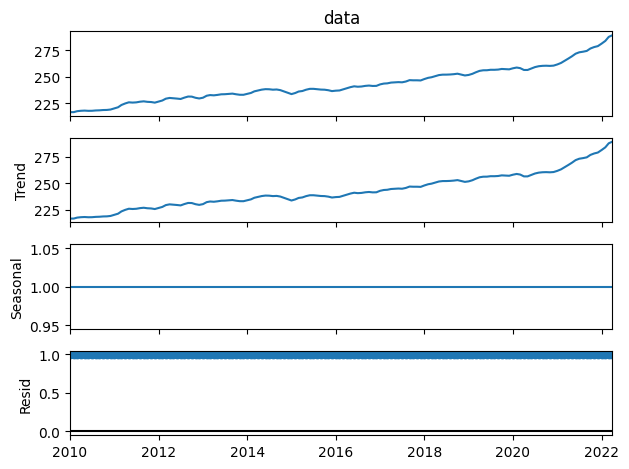

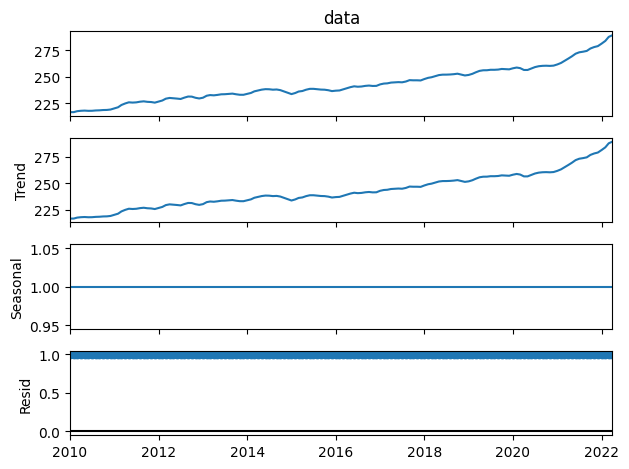

In [ ]:
d= seasonal_decompose(df['data'],model="multiplicative",period=1)
d.plot()

**On decomposing the data we see that, only one component- Trend, is present in the Data.**

So,the trend values are,

In [ ]:
d.trend

sl no.
2010-01-01    216.687
2010-02-01    216.741
2010-03-01    217.631
2010-04-01    218.009
2010-05-01    218.178
               ...   
2021-12-01    278.802
2022-01-01    281.148
2022-02-01    283.716
2022-03-01    287.504
2022-04-01    289.109
Name: trend, Length: 148, dtype: float64

**NOW WE USE DIFFERENT TRANSFORMATIONS TO TRANSFORM THE DATA TO STATIONARY**

Text(0, 0.5, 'Second Order Differencing Values')

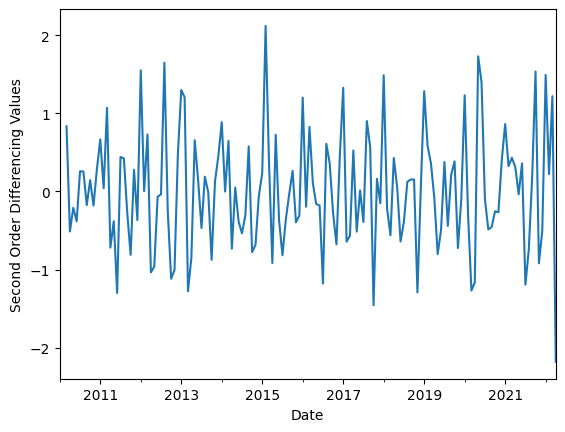

In [ ]:
df['data_diff'] = df['data'].diff(1).diff(1)
df['data_diff'] =df['data_diff'].dropna()
df['data_diff'].plot()
df['data_diff']
plt.xlabel("Date")
plt.ylabel("Second Order Differencing Values")

CHECKING IF ON TRANSFORMATION THE DATA BECOMES STATIONARY OR NOT BY AD FULLER TEST.

In [ ]:
atest2=adfuller(df['data_diff'].dropna(), autolag='AIC')
print("ADF statistic: ",atest2[0])
print("P-value: ",atest2[1])
for key, value in atest2[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF statistic:  -7.472222353448878
P-value:  5.019872371783548e-11
Critial Values:
   1%, -3.479742586699182
Critial Values:
   5%, -2.88319822181578
Critial Values:
   10%, -2.578319684499314


HENCE WE ACCEPT H0.

THUS ON DOING SECOND ORDER DIFFERENCING OF ORDER 1 THE DATA BECOMES STATIONARY.

NEXT WE PLOT THE ACF AND PACF OF THE TRANSFORMED DATA.

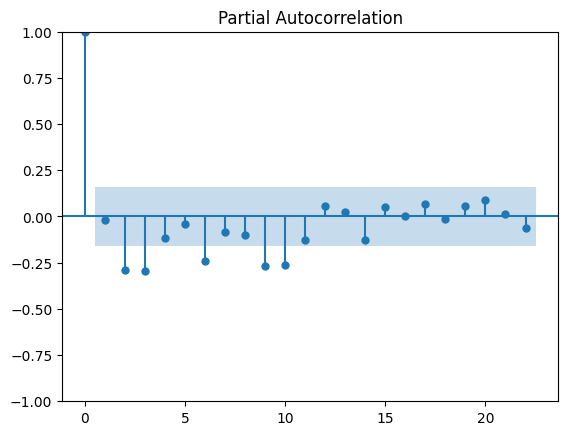

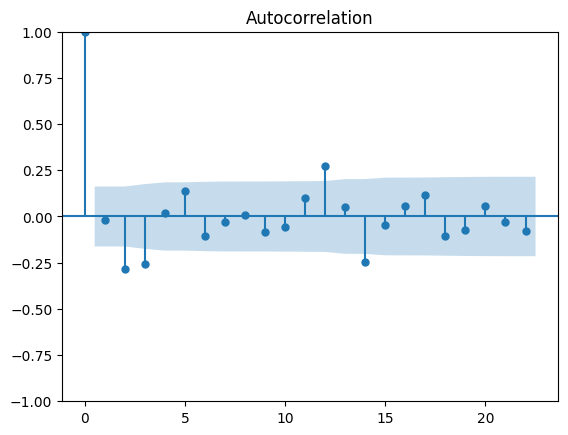

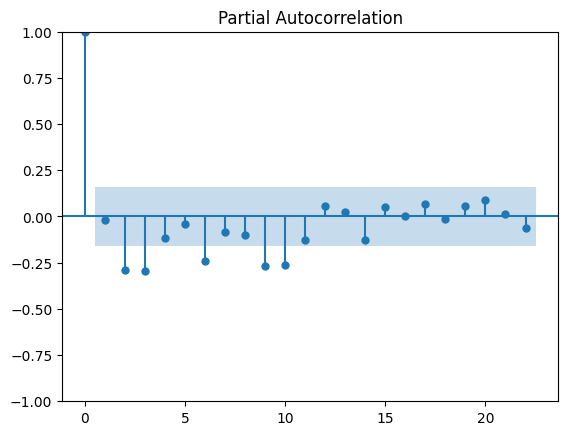

In [ ]:
plot_acf(df['data_diff'].dropna())
plot_pacf(df['data_diff'].dropna())

DETERMING OF MODEL FROM AIC AND BIC VALUES.

In [ ]:
for i in range(1,4):
  for j in range(1,4):
    mod = ARIMA(df['data'], order=(i,2,j))
    rslt1 = mod.fit()
    print('ARIMA{} - AIC:{} - BIC:{}'.format((i,2,j), rslt1.aic, rslt1.bic))

ARIMA(1, 2, 1) - AIC:305.706027914469 - BIC:314.65684777959405
ARIMA(1, 2, 2) - AIC:298.1966674620787 - BIC:310.13109394891205
ARIMA(1, 2, 3) - AIC:297.53748411254446 - BIC:312.45551722108615
ARIMA(2, 2, 1) - AIC:294.5728856837659 - BIC:306.5073121705992
ARIMA(2, 2, 2) - AIC:296.4875226783099 - BIC:311.4055557868516
ARIMA(2, 2, 3) - AIC:295.9401668619015 - BIC:313.8418065921515
ARIMA(3, 2, 1) - AIC:296.4534080151691 - BIC:311.3714411237108
ARIMA(3, 2, 2) - AIC:297.581930480473 - BIC:315.483570210723
ARIMA(3, 2, 3) - AIC:296.0728060472721 - BIC:316.95805239923044


HERE AIC AND BIC VALUES ARE MINIMUM ON A CERTAIN PARAMETER.

SPLITTING THE DATA INTO TRAINING AND TESTING DATA.

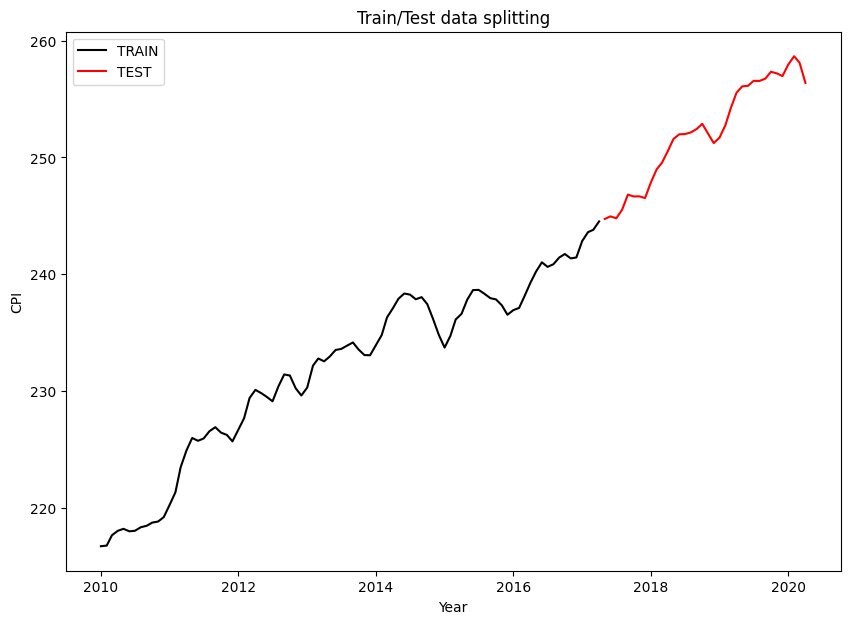

In [ ]:
df['sl no.'] = df.index
train = df[df['sl no.'] < pd.to_datetime("2017-05-01", format='%Y-%m-%d')]
train['train'] = train['data']
del train['sl no.']

t = df[df['sl no.'] >= pd.to_datetime("2017-05-01", format='%Y-%m-%d')]
t['sl no.'] = t.index
test=t[t['sl no.'] < pd.to_datetime("2020-05-01", format='%Y-%m-%d')]
test['test'] = test['data']
del test['sl no.']

plt.figure(figsize=(10,7))
plt.plot(train['train'], color = "black")
plt.plot(test['test'], color = "red")
plt.title("Train/Test data splitting")
plt.ylabel("CPI")
plt.xlabel('Year')
plt.legend(["TRAIN","TEST"])

PREDICTING THE FUTURE VALUES.

Text(0.5, 0, 'Year')

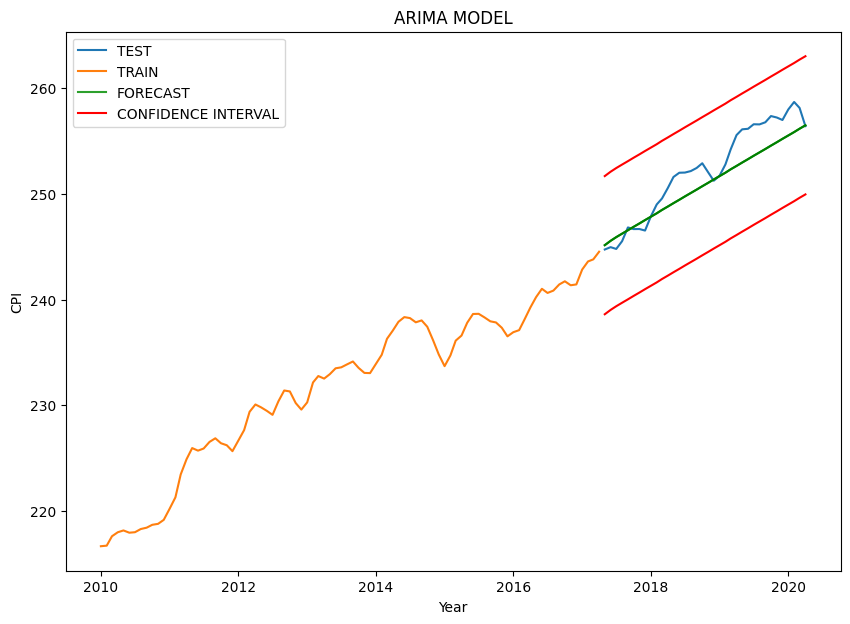

In [ ]:
model = ARIMA(train['train'], order=(1,2,2))
result=model.fit()
forecast = result.predict('2017-05-01','2020-04-01')
plt.figure(figsize=(10,7))
plt.plot(test['test'])
plt.plot(train['train'])

plt.plot(forecast)
plt.title("ARIMA MODEL")


y = (forecast)
ci = 1.96 * np.std(y)
# Plot the sinus function
#plt.plot(y)
# Plot the confidence interval
plt.plot( (y-ci), color='red')
plt.plot( (y+ci), color='red')
plt.plot(y,color='green')

plt.legend(["TEST","TRAIN","FORECAST","CONFIDENCE INTERVAL"])
plt.ylabel("CPI")
plt.xlabel('Year')

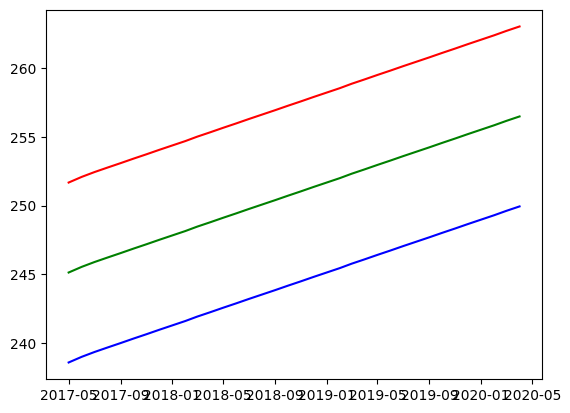

In [ ]:

y = (forecast)

ci = 1.96 * np.std(y)
# Plot the sinus function
#plt.plot(y)
# Plot the confidence interval
plt.plot( (y-ci), color='blue')
plt.plot( (y+ci), color='red')
plt.plot(y,color='green')


#print((y-ci), (y+ci))

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(test['test'] ,forecast))
print("MEAN SQ ERROR FOR ARIMA(1,2,2) MODEL", rms)

MEAN SQ ERROR FOR ARIMA(1,2,2) MODEL 1.885805442705394


Text(0.5, 0, 'Year')

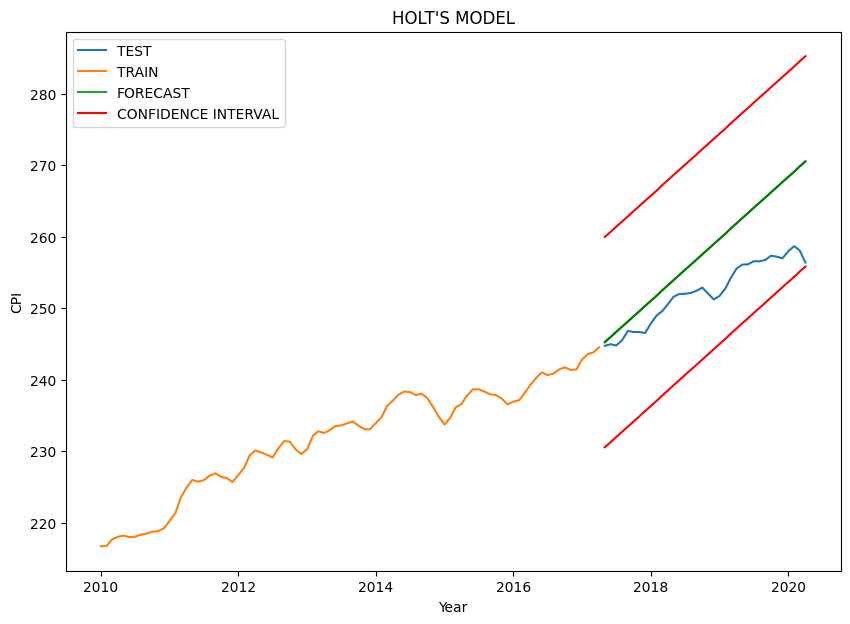

In [ ]:
fit1 = Holt(train['train']).fit()
forecast2= fit1.forecast(36)
plt.figure(figsize=(10,7))
plt.plot(test['test'])
plt.plot(train['train'])

plt.plot(forecast2)
plt.title("HOLT'S MODEL")

y = (forecast2)
ci = 1.96 * np.std(y)
plt.plot( (y-ci), color='red')
plt.plot( (y+ci), color='red')
plt.plot(y,color='green')

plt.legend(["TEST","TRAIN","FORECAST","CONFIDENCE INTERVAL"])
plt.ylabel("CPI")
plt.xlabel('Year')

In [ ]:
rms2 = sqrt(mean_squared_error(test['test'] ,forecast2))
print("MEAN SQ ERROR FOR HOLT'S MODEL", rms2)

MEAN SQ ERROR FOR HOLT'S MODEL 6.656133602369144


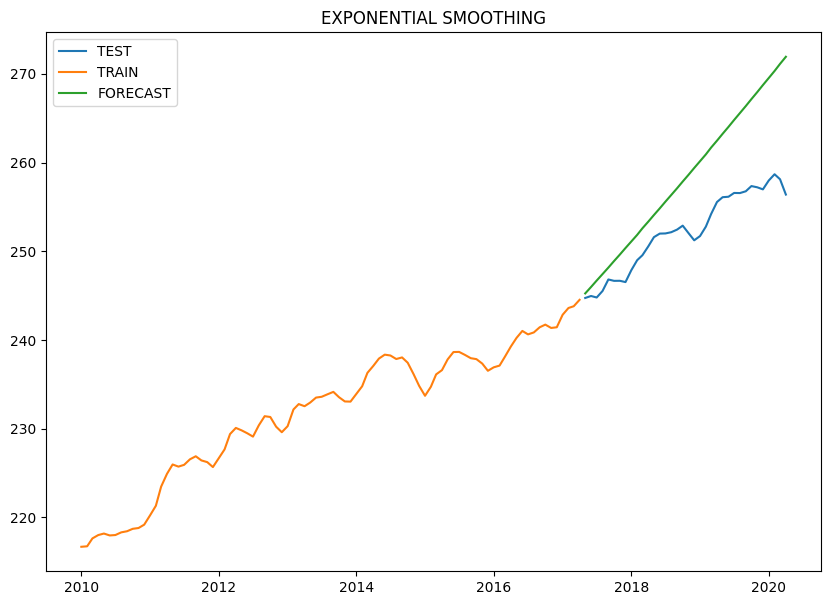

In [ ]:
model3 = ExponentialSmoothing(train['train'],trend='mul').fit()
forecast3 = model3.forecast(36)
plt.figure(figsize=(10,7))
plt.plot(test['test'])
plt.plot(train['train'])

plt.plot(forecast3)
plt.title("EXPONENTIAL SMOOTHING")
plt.legend(["TEST","TRAIN","FORECAST"])

In [ ]:
rms = sqrt(mean_squared_error(test['test'] ,forecast3))
print(rms)

7.264911030650898


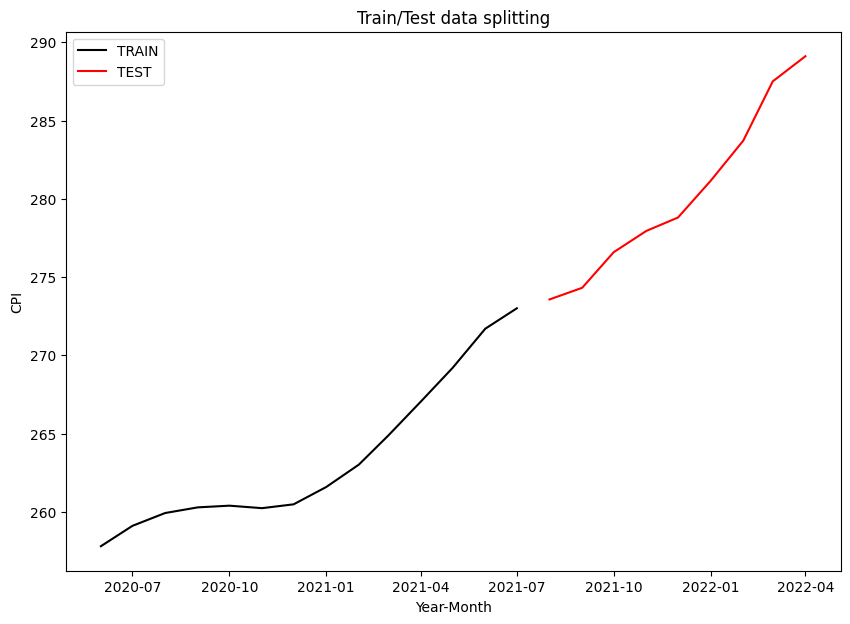

In [ ]:
df['sl no.'] = df.index
t2= df[df['sl no.'] > pd.to_datetime("2020-05-01", format='%Y-%m-%d')]
train2= t2[t2['sl no.'] < pd.to_datetime("2021-08-01", format='%Y-%m-%d')]

train2['train'] = train2['data']
del train2['sl no.']


test2 = df[df['sl no.'] >= pd.to_datetime("2021-08-01", format='%Y-%m-%d')]
test2['test'] = test2['data']
del test2['sl no.']

plt.figure(figsize=(10,7))
plt.plot(train2['train'], color = "black")
plt.plot(test2['test'], color = "red")
plt.title("Train/Test data splitting")
plt.ylabel("CPI")
plt.xlabel('Year-Month')
plt.legend(["TRAIN","TEST"])

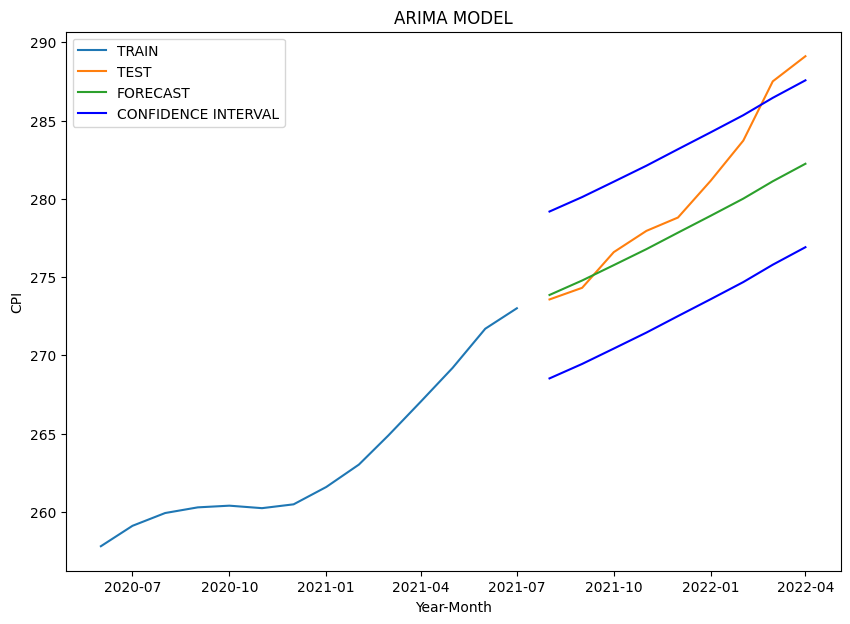

In [ ]:
model = ARIMA(train2['train'], order=(1,2,2))
result=model.fit()
forecastn = result.predict('2021-08-01','2022-04-01')
plt.figure(figsize=(10,7))

plt.plot(train2['train'])
plt.plot(test2['test'])

plt.title("ARIMA MODEL")

y = (forecastn)
ci = 1.96 * np.std(y)
# Plot the sinus function
#plt.plot(y)
# Plot the confidence interval
plt.plot(y)
plt.plot( (y-ci), color='blue')
plt.plot( (y+ci), color='blue')

plt.ylabel("CPI")
plt.xlabel('Year-Month')

plt.legend(["TRAIN","TEST","FORECAST","CONFIDENCE INTERVAL"])



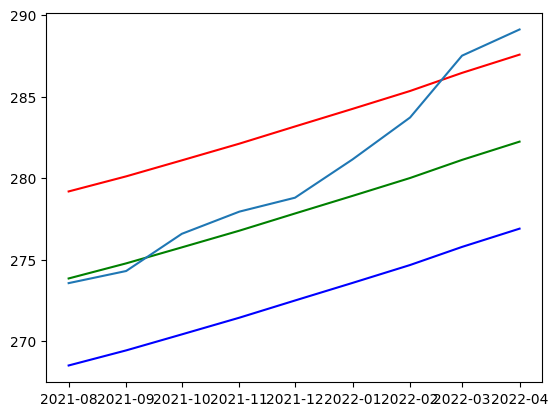

In [ ]:
y = (forecastn)
ci = 1.96 * np.std(y)
# Plot the sinus function
#plt.plot(y)
# Plot the confidence interval
plt.plot( (y-ci), color='blue')
plt.plot( (y+ci), color='red')
plt.plot(y,color='green')
plt.plot(test2['test'])

In [ ]:
rms = sqrt(mean_squared_error(test2['test'] ,forecastn))
print(rms)

3.496655809821376


In [ ]:
forecastn

2021-08-01    273.853061
2021-09-01    274.777709
2021-10-01    275.758342
2021-11-01    276.780998
2021-12-01    277.835196
2022-01-01    278.913070
2022-02-01    280.008716
2022-03-01    281.117700
2022-04-01    282.236697
Freq: MS, Name: predicted_mean, dtype: float64

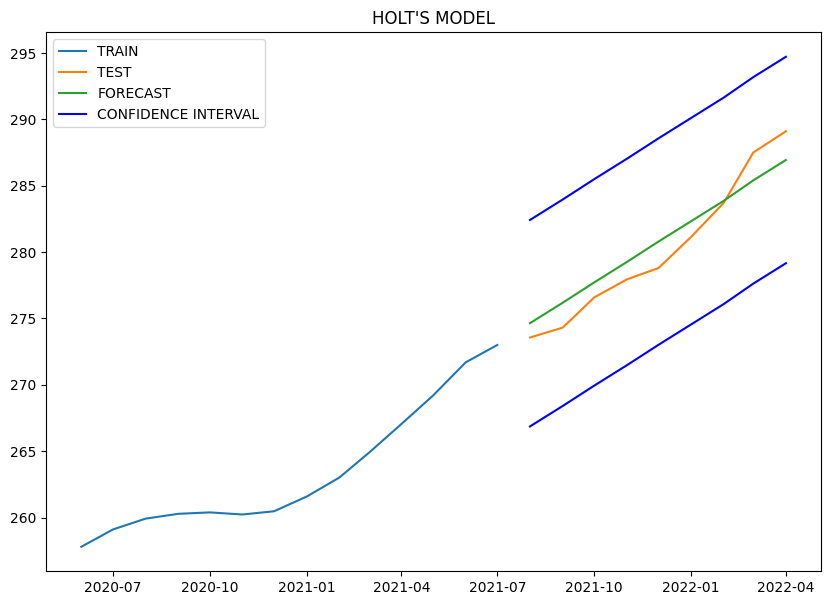

In [ ]:
fit12 = Holt(train2['train']).fit()
forecastn2= fit12.forecast(9)
plt.figure(figsize=(10,7))

plt.plot(train2['train'])
plt.plot(test2['test'])


plt.plot(forecastn2)
plt.title("HOLT'S MODEL")

y = (forecastn2)
ci = 1.96 * np.std(y)
plt.plot( (y-ci), color='blue')
plt.plot( (y+ci), color='blue')



plt.legend(["TRAIN","TEST","FORECAST","CONFIDENCE INTERVAL"])



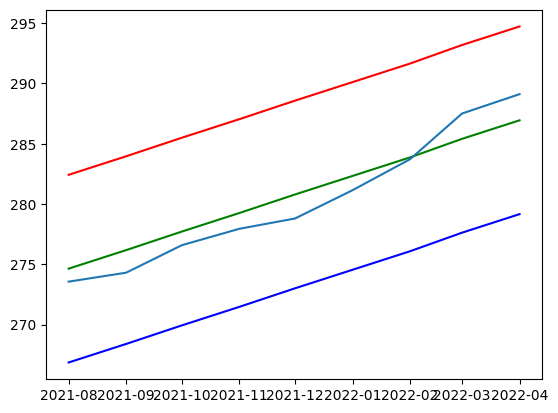

In [ ]:
y = (forecastn2)
ci = 1.96 * np.std(y)
plt.plot( (y-ci), color='blue')
plt.plot( (y+ci), color='red')
plt.plot(y,color='green')
plt.plot(test2['test'])

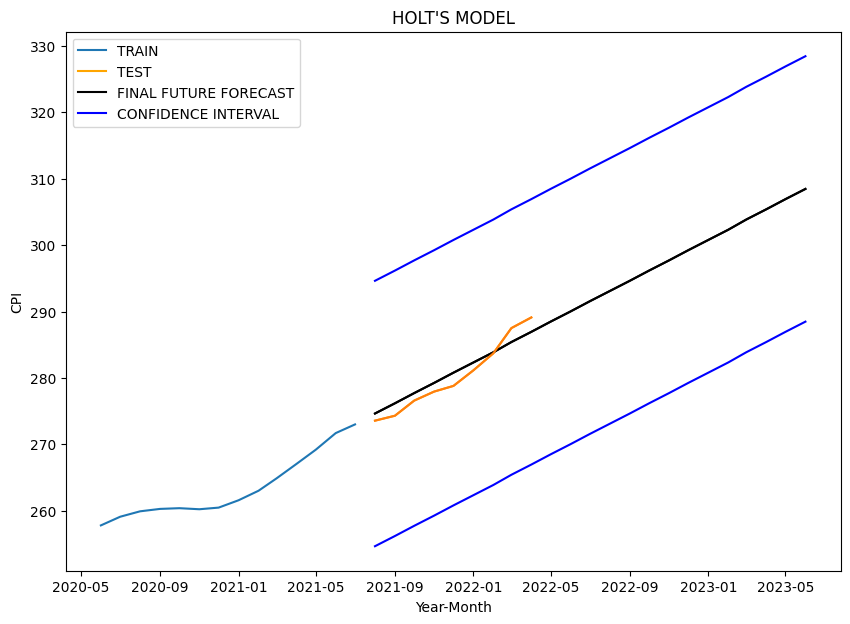

In [ ]:
forecastfinal= fit12.forecast(23)
plt.figure(figsize=(10,7))
plt.plot(train2['train'])
plt.plot(test2['test'],color='orange')


plt.title("HOLT'S MODEL")

y = (forecastfinal)
ci = 1.96 * np.std(y)
# Plot the sinus function
#plt.plot(y)
# Plot the confidence interval
plt.plot(y,color='black')
plt.plot( (y-ci), color='blue')
plt.plot( (y+ci), color='blue')
plt.plot(y,color='black')

plt.ylabel("CPI")
plt.xlabel('Year-Month')
plt.plot(test2['test'])
plt.legend(["TRAIN","TEST","FINAL FUTURE FORECAST","CONFIDENCE INTERVAL"])

In [ ]:
forecastfinal

2021-08-01    274.644484
2021-09-01    276.181566
2021-10-01    277.718648
2021-11-01    279.255730
2021-12-01    280.792812
2022-01-01    282.329894
2022-02-01    283.866976
2022-03-01    285.404058
2022-04-01    286.941140
2022-05-01    288.478222
2022-06-01    290.015304
2022-07-01    291.552386
2022-08-01    293.089468
2022-09-01    294.626550
2022-10-01    296.163632
2022-11-01    297.700714
2022-12-01    299.237796
2023-01-01    300.774878
2023-02-01    302.311960
2023-03-01    303.849042
2023-04-01    305.386124
2023-05-01    306.923206
2023-06-01    308.460288
Freq: MS, dtype: float64

In [ ]:

rmsn2 = sqrt(mean_squared_error(test2['test'] ,forecastn2))
print("MEAN SQ ERROR FOR HOLT'S MODEL", rmsn2)

MEAN SQ ERROR FOR HOLT'S MODEL 1.5685226435123467


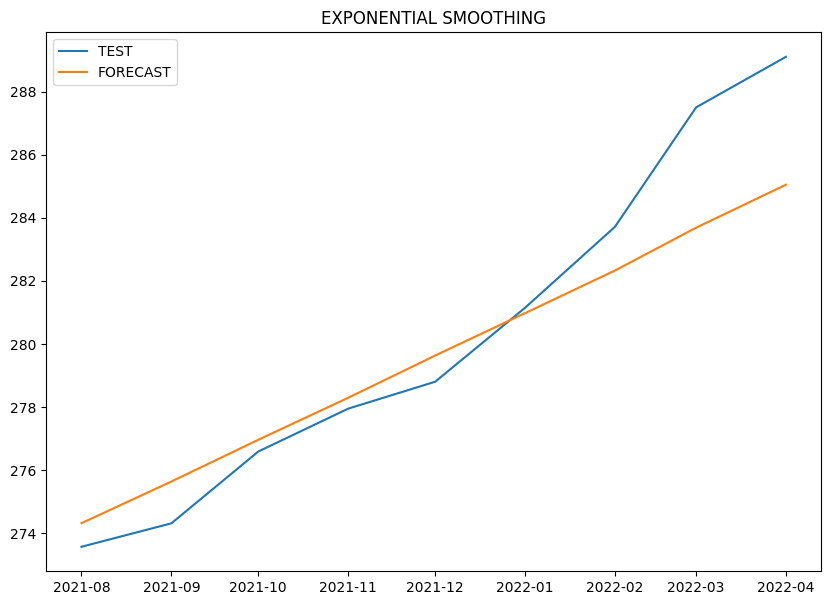

In [ ]:
modeln3 = ExponentialSmoothing(train2['train'],trend='mul').fit()
forecastn3 = modeln3.forecast(9)
plt.figure(figsize=(10,7))
plt.plot(test2['test'])
plt.plot(forecastn3)
plt.title("EXPONENTIAL SMOOTHING")
plt.legend(["TEST","FORECAST"])


In [ ]:
forecastn3

2021-08-01    274.316287
2021-09-01    275.635892
2021-10-01    276.961845
2021-11-01    278.294177
2021-12-01    279.632918
2022-01-01    280.978098
2022-02-01    282.329750
2022-03-01    283.687904
2022-04-01    285.052592
Freq: MS, dtype: float64

In [ ]:

rms3 = sqrt(mean_squared_error(test2['test'] ,forecastn3))
print("MEAN SQ ERROR FOR XPONENTIAL SMOOTHING MODEL",rms3)

MEAN SQ ERROR FOR XPONENTIAL SMOOTHING MODEL 2.006552896298696


In [ ]:
forecastfinal.to_excel('MY WORK.xlsx')

# New Section

In [ ]:
forecast

2017-05-01    245.142740
2017-06-01    245.554281
2017-07-01    245.902283
2017-08-01    246.230801
2017-09-01    246.553344
2017-10-01    246.874056
2017-11-01    247.194205
2017-12-01    247.514182
2018-01-01    247.834106
2018-02-01    248.154014
2018-03-01    248.473917
2018-04-01    248.793818
2018-05-01    249.113719
2018-06-01    249.433620
2018-07-01    249.753521
2018-08-01    250.073422
2018-09-01    250.393323
2018-10-01    250.713223
2018-11-01    251.033124
2018-12-01    251.353025
2019-01-01    251.672926
2019-02-01    251.992827
2019-03-01    252.312727
2019-04-01    252.632628
2019-05-01    252.952529
2019-06-01    253.272430
2019-07-01    253.592330
2019-08-01    253.912231
2019-09-01    254.232132
2019-10-01    254.552033
2019-11-01    254.871934
2019-12-01    255.191834
2020-01-01    255.511735
2020-02-01    255.831636
2020-03-01    256.151537
2020-04-01    256.471438
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
forecast2

2017-05-01    245.246810
2017-06-01    245.969620
2017-07-01    246.692429
2017-08-01    247.415239
2017-09-01    248.138049
2017-10-01    248.860859
2017-11-01    249.583669
2017-12-01    250.306479
2018-01-01    251.029288
2018-02-01    251.752098
2018-03-01    252.474908
2018-04-01    253.197718
2018-05-01    253.920528
2018-06-01    254.643337
2018-07-01    255.366147
2018-08-01    256.088957
2018-09-01    256.811767
2018-10-01    257.534577
2018-11-01    258.257387
2018-12-01    258.980196
2019-01-01    259.703006
2019-02-01    260.425816
2019-03-01    261.148626
2019-04-01    261.871436
2019-05-01    262.594245
2019-06-01    263.317055
2019-07-01    264.039865
2019-08-01    264.762675
2019-09-01    265.485485
2019-10-01    266.208294
2019-11-01    266.931104
2019-12-01    267.653914
2020-01-01    268.376724
2020-02-01    269.099534
2020-03-01    269.822344
2020-04-01    270.545153
Freq: MS, dtype: float64

In [ ]:
forecast3

2017-05-01    245.246386
2017-06-01    245.970906
2017-07-01    246.697566
2017-08-01    247.426374
2017-09-01    248.157334
2017-10-01    248.890454
2017-11-01    249.625739
2017-12-01    250.363197
2018-01-01    251.102833
2018-02-01    251.844655
2018-03-01    252.588668
2018-04-01    253.334879
2018-05-01    254.083294
2018-06-01    254.833921
2018-07-01    255.586765
2018-08-01    256.341833
2018-09-01    257.099132
2018-10-01    257.858668
2018-11-01    258.620448
2018-12-01    259.384478
2019-01-01    260.150766
2019-02-01    260.919317
2019-03-01    261.690139
2019-04-01    262.463238
2019-05-01    263.238621
2019-06-01    264.016294
2019-07-01    264.796265
2019-08-01    265.578541
2019-09-01    266.363127
2019-10-01    267.150031
2019-11-01    267.939260
2019-12-01    268.730821
2020-01-01    269.524720
2020-02-01    270.320964
2020-03-01    271.119561
2020-04-01    271.920517
Freq: MS, dtype: float64